# 1️⃣ Data Preparation

In [1]:
import random, numpy as np, pandas as pd, torch
from datasets import load_dataset
from sklearn.preprocessing import LabelEncoder

SEED = 322
rng = np.random.RandomState(SEED)
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

In [3]:
# Load HF dataset
ds = load_dataset("marekk/testing_dataset_article_category")
df = ds["train"].to_pandas()

# Fill NaNs
df["title"] = df["title"].fillna("")
df["perex"] = df["perex"].fillna("")
df["full_text"] = df["title"] + "\n\n" + df["perex"]

print("Raw shape:", df.shape)
print(df["label"].value_counts().sort_index())


Raw shape: (1500, 4)
label
Injuries      100
Interview     100
Pre-Match     100
Reaction     1000
Report        100
Transfers     100
Name: count, dtype: int64


In [4]:
# Drop exact duplicates (same text + same label)
df_unique = df.drop_duplicates(subset=["full_text", "label"]).copy()

# Resolve conflicting labels for the same text: keep minority label
label_counts = df_unique["label"].value_counts()
label_sets = (
    df_unique.groupby("full_text")["label"]
             .apply(lambda s: sorted(set(s)))
             .reset_index(name="labels")
)
multi = label_sets[label_sets["labels"].apply(len) > 1]

def pick_label(labels):
    counts = [(lab, label_counts.get(lab, 0)) for lab in labels]
    minc = min(c for _, c in counts)
    cands = sorted([lab for lab, c in counts if c == minc])
    return cands[0]

chosen = {row.full_text: pick_label(row.labels) for row in multi.itertuples()}

df_clean = df_unique[
    ~df_unique["full_text"].isin(chosen.keys()) |
    (df_unique["label"] == df_unique["full_text"].map(chosen))
].copy()

print("After dedup/conflict-resolve:", df_clean.shape)
print(df_clean["label"].value_counts().sort_index())

After dedup/conflict-resolve: (1474, 4)
label
Injuries      99
Interview     85
Pre-Match     97
Reaction     999
Report        96
Transfers     98
Name: count, dtype: int64


In [5]:
# Build final text column (no extra preprocessing for transformers)
df_clean["text"] = df_clean["title"] + "\n\n" + df_clean["perex"]
df_clean = df_clean[["text", "label"]].reset_index(drop=True)
df_clean.head(3)

,text,label
0,Realu se vážně zranil Asensio. Ceballos by měl...,Injuries
1,Problémy s koleny dohnaly Richardse k brzkému ...,Injuries
2,Verletzungspech bei Real - Kreuzband-Schock fü...,Injuries


In [6]:
# Make balanced VAL/TEST (equal per class), rest -> TRAIN
counts = df_clean["label"].value_counts()
k_each = int(np.floor(counts.min() * 0.20))
k_each = max(1, k_each)

val_idx, test_idx = [], []
for lab in counts.index.tolist():
    idx = df_clean.index[df_clean["label"] == lab].to_numpy()
    rng.shuffle(idx)
    val_idx.extend(idx[:k_each])
    test_idx.extend(idx[k_each:2*k_each])

val_idx, test_idx = set(val_idx), set(test_idx)
all_eval = val_idx | test_idx

val_df   = df_clean.loc[list(val_idx)].reset_index(drop=True)
test_df  = df_clean.loc[list(test_idx)].reset_index(drop=True)
train_df = df_clean.drop(index=list(all_eval)).reset_index(drop=True)

print("Shapes  ->  train/val/test:", train_df.shape, val_df.shape, test_df.shape)
print("VAL per class:\n",  val_df["label"].value_counts().sort_index())
print("TEST per class:\n", test_df["label"].value_counts().sort_index())

Shapes  ->  train/val/test: (1270, 2) (102, 2) (102, 2)
VAL per class:
 label
Injuries     17
Interview    17
Pre-Match    17
Reaction     17
Report       17
Transfers    17
Name: count, dtype: int64
TEST per class:
 label
Injuries     17
Interview    17
Pre-Match    17
Reaction     17
Report       17
Transfers    17
Name: count, dtype: int64


In [7]:
# Label encoding
le = LabelEncoder().fit(df_clean["label"])

train_df["label_id"] = le.transform(train_df["label"])
val_df["label_id"]   = le.transform(val_df["label"])
test_df["label_id"]  = le.transform(test_df["label"])

id2label = {i: c for i, c in enumerate(le.classes_)}
label2id = {v: k for k, v in id2label.items()}

print("Classes:", id2label)
train_df.head(2)

Classes: {0: 'Injuries', 1: 'Interview', 2: 'Pre-Match', 3: 'Reaction', 4: 'Report', 5: 'Transfers'}


,text,label,label_id
0,Realu se vážně zranil Asensio. Ceballos by měl...,Injuries,0
1,Problémy s koleny dohnaly Richardse k brzkému ...,Injuries,0


Token length percentiles [50,75,90,95,98,99]: [67, 96, 136, 162, 195, 207]
Suggested max_length (≈95th pct): 162
Coverage if max_length=160: 0.946
Coverage if max_length=192: 0.978
Coverage if max_length=256: 1.0


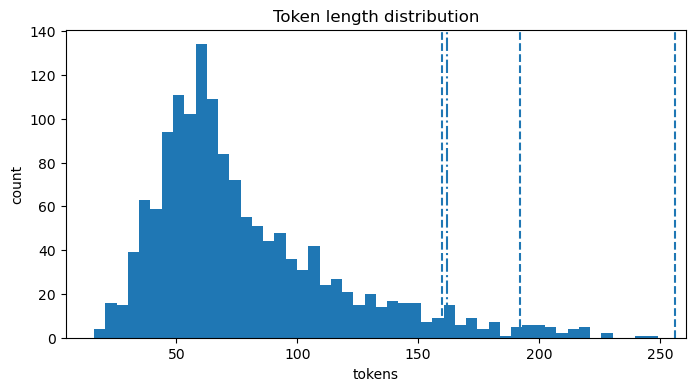

In [22]:
# Token-length EDA
import numpy as np, matplotlib.pyplot as plt
from transformers import AutoTokenizer

MODEL_NAME = "xlm-roberta-base"  # same as training
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

texts = df_clean["text"].tolist()
lengths = [len(tokenizer(t, add_special_tokens=True, truncation=False)["input_ids"]) for t in texts]
lengths = np.asarray(lengths, dtype=int)

# Percentiles + suggestion
pcts = np.percentile(lengths, [50, 75, 90, 95, 98, 99]).astype(int)
suggested = int(np.percentile(lengths, 95))  # typical trade-off

print("Token length percentiles [50,75,90,95,98,99]:", pcts.tolist())
print("Suggested max_length (≈95th pct):", suggested)

# Coverage for common caps
for cap in (160, 192, 256):
    cov = np.mean(lengths <= cap)
    print(f"Coverage if max_length={cap}:", np.round(cov, 3))

# Plot histogram + reference lines
plt.figure(figsize=(8,4))
plt.hist(lengths, bins=50)
plt.title("Token length distribution")
plt.xlabel("tokens"); plt.ylabel("count")

for x, ls in [(160, "--"), (192, "--"), (256, "--"), (suggested, "-.")]:
    plt.axvline(x, linestyle=ls)

plt.show()

What I did and why:
 - **Dataset & text field**:

        Merged title + perex → text. Kept raw multilingual text (≈30 languages), no heavy cleaning needed for Transformers.
   
 - **Duplicates**:
   
        Removed exact duplicates of text within the same label.

        Found only 4 conflicts where the same text had different labels; didn’t turn this into a multi-label task.

 - **Imbalance**:

        Strong skew toward Reaction. I did not downsample TRAIN; instead, handled imbalance later in modeling.

 - **Splits**:

       Built balanced VAL/TEST (equal count per class, ~20%+20%); the rest is TRAIN.

 - **Length EDA**:

       Token length percentiles suggested max_len ≈ 160 (95th pct ~162). Used dynamic padding during training.

# 2️⃣ Baseline Models

Goal: establish a strong, fast lower bound and sanity-check the splits before fine-tuning Transformers.

In [8]:
import numpy as np, pandas as pd
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, classification_report
import joblib

In [9]:
# Build shared TF-IDF features 
# word 1-2 and char 3-6 n-grams
word_vec = TfidfVectorizer(
    analyzer="word",
    ngram_range=(1,2),
    min_df=1,
    max_df=0.99,
    sublinear_tf=True
)
char_vec = TfidfVectorizer(
    analyzer="char",
    ngram_range=(3,6),
    min_df=1,
    sublinear_tf=True
)

Xtr_w = word_vec.fit_transform(train_df["text"])
Xva_w = word_vec.transform(val_df["text"])

Xtr_c = char_vec.fit_transform(train_df["text"])
Xva_c = char_vec.transform(val_df["text"])

Xtr = hstack([Xtr_w, Xtr_c]).tocsr()
Xva = hstack([Xva_w, Xva_c]).tocsr()

y_train = train_df["label_id"].values
y_val   = val_df["label_id"].values

Xtr.shape, Xva.shape

((1270, 511891), (102, 511891))

In [10]:
#  train/eval loops with small param sweeps

def _eval_val(clf, Xva, yva):
    pred = clf.predict(Xva)
    return {
        "acc": accuracy_score(yva, pred),
        "macro_f1": f1_score(yva, pred, average="macro"),
        "micro_f1": f1_score(yva, pred, average="micro"),
    }

def sweep_linear_svc(Xtr, ytr, Xva, yva, Cs=(0.25, 0.5, 1.0, 2.0, 4.0), seed=42):
    rows = []
    for C in Cs:
        clf = LinearSVC(C=C, class_weight="balanced", max_iter=10000, random_state=seed)
        clf.fit(Xtr, ytr)
        m = _eval_val(clf, Xva, yva)
        rows.append({"model":"LinearSVC","C":C, **m, "clf":clf})
    # best by macro-F1 and by accuracy
    best_macro = max(rows, key=lambda r: r["macro_f1"])
    best_acc   = max(rows, key=lambda r: r["acc"])
    table = pd.DataFrame([{k:v for k,v in r.items() if k!="clf"} for r in rows]).sort_values("C")
    return best_macro, best_acc, table

def sweep_logreg(Xtr, ytr, Xva, yva, Cs=(0.25, 0.5, 1.0, 2.0, 4.0), seed=42):
    rows = []
    for C in Cs:
        clf = LogisticRegression(
            C=C, penalty="l2", solver="saga", max_iter=5000,
            class_weight="balanced", n_jobs=-1, multi_class="multinomial", random_state=seed
        )
        clf.fit(Xtr, ytr)
        m = _eval_val(clf, Xva, yva)
        rows.append({"model":"LogReg_saga","C":C, **m, "clf":clf})
    best_macro = max(rows, key=lambda r: r["macro_f1"])
    best_acc   = max(rows, key=lambda r: r["acc"])
    table = pd.DataFrame([{k:v for k,v in r.items() if k!="clf"} for r in rows]).sort_values("C")
    return best_macro, best_acc, table

def sweep_nb(Xtr, ytr, Xva, yva, alphas=(0.1, 0.3, 0.7, 1.0, 2.0)):
    rows = []
    for a in alphas:
        clf = MultinomialNB(alpha=a)
        clf.fit(Xtr, ytr)
        m = _eval_val(clf, Xva, yva)
        rows.append({"model":"MultinomialNB","alpha":a, **m, "clf":clf})
    best_macro = max(rows, key=lambda r: r["macro_f1"])
    best_acc   = max(rows, key=lambda r: r["acc"])
    table = pd.DataFrame([{k:v for k,v in r.items() if k!="clf"} for r in rows]).sort_values("alpha")
    return best_macro, best_acc, table

In [11]:
# Run sweeps and print concise bests
best_svm_macro, best_svm_acc, _ = sweep_linear_svc(Xtr, y_train, Xva, y_val)
best_lr_macro,  best_lr_acc,  _ = sweep_logreg(Xtr, y_train, Xva, y_val)
best_nb_macro,  best_nb_acc,  _ = sweep_nb(Xtr, y_train, Xva, y_val)

print("=== LinearSVC ===")
print(f"Best by macro-F1: macro-F1={best_svm_macro['macro_f1']:.4f}, acc={best_svm_macro['acc']:.4f}, C={best_svm_macro['C']}")
print(f"Best by accuracy: acc={best_svm_acc['acc']:.4f}, macro-F1={best_svm_acc['macro_f1']:.4f}, C={best_svm_acc['C']}")

print("\n=== LogisticRegression (saga, multinomial) ===")
print(f"Best by macro-F1: macro-F1={best_lr_macro['macro_f1']:.4f}, acc={best_lr_macro['acc']:.4f}, C={best_lr_macro['C']}")
print(f"Best by accuracy: acc={best_lr_acc['acc']:.4f}, macro-F1={best_lr_acc['macro_f1']:.4f}, C={best_lr_acc['C']}")

print("\n=== MultinomialNB ===")
print(f"Best by macro-F1: macro-F1={best_nb_macro['macro_f1']:.4f}, acc={best_nb_macro['acc']:.4f}, alpha={best_nb_macro['alpha']}")
print(f"Best by accuracy: acc={best_nb_acc['acc']:.4f}, macro-F1={best_nb_acc['macro_f1']:.4f}, alpha={best_nb_acc['alpha']}")

=== LinearSVC ===
Best by macro-F1: macro-F1=0.5809, acc=0.5490, C=4.0
Best by accuracy: acc=0.5490, macro-F1=0.5809, C=4.0

=== LogisticRegression (saga, multinomial) ===
Best by macro-F1: macro-F1=0.6443, acc=0.6373, C=0.5
Best by accuracy: acc=0.6373, macro-F1=0.6440, C=0.25

=== MultinomialNB ===
Best by macro-F1: macro-F1=0.2281, acc=0.2745, alpha=0.1
Best by accuracy: acc=0.2745, macro-F1=0.2281, alpha=0.1


### Baseline Results

Setup : TF-IDF (word 1–2 + char 3–6), balanced VAL/TEST, class weighting where applicable.

Models tested:
- **LinearSVC** → macro-F1 0.58, acc 0.54 (C=4.0).
- **Logistic Regression** (saga, multinomial) → macro-F1 0.64, acc 0.63.
- **MultinomialNB** → macro-F1 0.22, acc 0.27 (alpha=0.1).

Logistic Regression is the strongest classical baseline here: it handles the sparse multilingual TF-IDF space well and benefits from class weighting; scores set a credible floor (~0.64 macro-F1)

What this means:

The task is **learnable** from surface features; TF-IDF already captures enough signal. Any Transformer we keep should beat ~0.64 macro-F1 on VAL to justify the complexity

# 3️⃣ Transformer Model

Here I'll try to tune two multilingual encoders: XLM-RoBERTa base and mDeBERTa-v3 base.
 - Text. Use raw title + perex. MAX_LEN = 160. Dynamic padding via DataCollatorWithPadding.
 - Imbalance. Handle in training: WeightedRandomSampler (per-class inverse frequency) + CrossEntropy with label smoothing = 0.1
 - Fine-tuning. Partial unfreeze (top 4 encoder layers + classifier head). Two LRs: encoder 2e-5, head 1e-3, weight_decay=0.01, linear warmup 10%.
 - Training loop. Mixed precision (AMP), grad clipping, progress bars, early stopping by VAL macro-F1 (patience=3), max 10 epochs.

In [12]:
import os, math, time, numpy as np, torch, torch.nn as nn
from collections import Counter
from sklearn.metrics import accuracy_score, f1_score, classification_report
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, SequentialSampler
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          DataCollatorWithPadding, get_linear_schedule_with_warmup)
from torch.amp import GradScaler, autocast

os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
# Small dataset wrapper (tokenize on-the-fly; dynamic padding)
class TextClsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts.tolist()
        self.labels = labels.tolist()
        self.tok = tokenizer
        self.max_len = max_len
    def __len__(self): return len(self.texts)
    def __getitem__(self, i):
        enc = self.tok(
            self.texts[i],
            truncation=True,
            max_length=self.max_len,
            padding=False,  
            return_attention_mask=True
        )
        enc["labels"] = self.labels[i]
        return enc

In [14]:
# Build loaders with dynamic padding + weighted sampler
def build_loaders(model_name, max_len=160, batch_size=16):
    # tokenizer + dynamic padding that returns torch tensors
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
    collator  = DataCollatorWithPadding(tokenizer, pad_to_multiple_of=8, return_tensors="pt")

    train_ds  = TextClsDataset(train_df["text"], train_df["label_id"], tokenizer, max_len)
    val_ds    = TextClsDataset(val_df["text"],   val_df["label_id"],   tokenizer, max_len)
    test_ds   = TextClsDataset(test_df["text"],  test_df["label_id"],  tokenizer, max_len)

    # weighted sampler (handles imbalance)
    import numpy as np
    from collections import Counter
    y = np.array(train_df["label_id"].values)
    freq = Counter(y); class_w = {c: 1.0/f for c, f in freq.items()}
    sample_w = np.array([class_w[c] for c in y], dtype=np.float32)
    sampler  = WeightedRandomSampler(weights=sample_w, num_samples=len(sample_w), replacement=True)

    train_loader = DataLoader(
        train_ds, batch_size=batch_size, sampler=sampler,
        collate_fn=collator, num_workers=0, pin_memory=False
    )
    val_loader = DataLoader(
        val_ds, batch_size=batch_size, sampler=SequentialSampler(val_ds),
        collate_fn=collator, num_workers=0, pin_memory=False
    )
    test_loader = DataLoader(
        test_ds, batch_size=batch_size, sampler=SequentialSampler(test_ds),
        collate_fn=collator, num_workers=0, pin_memory=False
    )
    num_labels = int(train_df["label_id"].nunique())
    return tokenizer, train_loader, val_loader, test_loader, num_labels

In [15]:
# Partial unfreeze (last N encoder layers) + optimizer with two LRs
def prepare_model(model_name, num_labels, unfreeze_last_n=4, enc_lr=2e-5, head_lr=1e-3, wd=0.01):
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=num_labels, use_safetensors=True
    ).to(device)

    # Freeze all encoder; then unfreeze last N layers
    if hasattr(model, "roberta"):
        # XLM-R
        for p in model.roberta.parameters(): p.requires_grad = False
        layers = model.roberta.encoder.layer
    elif hasattr(model, "deberta"):
        # mDeBERTa
        for p in model.deberta.parameters(): p.requires_grad = False
        layers = model.deberta.encoder.layer
    else:
        raise ValueError("Unknown encoder attr (expected .roberta or .deberta)")

    for layer in layers[-unfreeze_last_n:]:
        for p in layer.parameters():
            p.requires_grad = True

    head_params = list(model.classifier.parameters())
    for p in head_params: p.requires_grad = True

    # Build optimizer with 2 param groups
    enc_params = []
    for layer in layers[-unfreeze_last_n:]:
        enc_params += list(layer.parameters())

    optimizer = AdamW([
        {"params": enc_params, "lr": enc_lr, "weight_decay": wd},
        {"params": head_params, "lr": head_lr, "weight_decay": wd},
    ])

    return model, optimizer


In [16]:
# Train/eval with label smoothing + early stopping (by macro-F1)
from tqdm.auto import tqdm, trange
from torch.amp import GradScaler, autocast
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score
from transformers import get_linear_schedule_with_warmup

def train_model(model_name, run_name, max_len=160, batch_size=16, epochs=10, patience=3,
                unfreeze_last_n=4, enc_lr=2e-5, head_lr=1e-3, wd=0.01, warmup_ratio=0.1, label_smooth=0.1):
    # Tokenizer + loaders
    tokenizer, train_loader, val_loader, test_loader, num_labels = build_loaders(
        model_name, max_len=max_len, batch_size=batch_size
    )
    # Model + optimizer
    model, optimizer = prepare_model(
        model_name, num_labels,
        unfreeze_last_n=unfreeze_last_n, enc_lr=enc_lr, head_lr=head_lr, wd=wd
    )

    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=int(warmup_ratio * total_steps), num_training_steps=total_steps
    )
    criterion = nn.CrossEntropyLoss(label_smoothing=label_smooth)

    amp_enabled = torch.cuda.is_available()
    scaler = GradScaler('cuda', enabled=amp_enabled)

    best_dir = f"{run_name}_best"
    os.makedirs(best_dir, exist_ok=True)
    best_f1, no_improve = -1.0, 0

    def _eval(loader, desc="val"):
        model.eval()
        loss_sum, gold, pred = 0.0, [], []
        with torch.no_grad():
            for batch in tqdm(loader, desc=f"[{run_name}] {desc}", leave=False):
                input_ids = batch["input_ids"].to(device, non_blocking=False)
                attn_mask = batch["attention_mask"].to(device, non_blocking=False)
                labels    = batch["labels"].to(device, non_blocking=False)
                with autocast('cuda', enabled=amp_enabled):
                    out = model(input_ids=input_ids, attention_mask=attn_mask)
                    loss = criterion(out.logits, labels)
                loss_sum += loss.item()
                pred.extend(out.logits.argmax(dim=1).detach().cpu().numpy().tolist())
                gold.extend(labels.detach().cpu().numpy().tolist())
        acc = accuracy_score(gold, pred)
        f1m = f1_score(gold, pred, average="macro")
        return loss_sum / max(1, len(loader)), acc, f1m

    for epoch in trange(1, epochs+1, desc=f"[{run_name}] epochs", leave=True):
        model.train()
        running_loss = 0.0
        batch_bar = tqdm(train_loader, desc=f"[{run_name}] train {epoch}/{epochs}", leave=False)
        for i, batch in enumerate(batch_bar, 1):
            input_ids = batch["input_ids"].to(device, non_blocking=False)
            attn_mask = batch["attention_mask"].to(device, non_blocking=False)
            labels    = batch["labels"].to(device, non_blocking=False)

            optimizer.zero_grad(set_to_none=True)
            with autocast('cuda', enabled=amp_enabled):
                out  = model(input_ids=input_ids, attention_mask=attn_mask)
                loss = criterion(out.logits, labels)

            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer); scaler.update()
            scheduler.step()

            running_loss += loss.item()
            lr_now = scheduler.get_last_lr()[0]
            batch_bar.set_postfix(loss=f"{running_loss/i:.4f}", lr=f"{lr_now:.2e}")

        va_loss, va_acc, va_f1 = _eval(val_loader, desc=f"val {epoch}/{epochs}")
        tqdm.write(f"[{run_name}] Epoch {epoch}/{epochs} | train_loss={running_loss/len(train_loader):.4f} "
                   f"| val_loss={va_loss:.4f} | val_acc={va_acc:.4f} | val_macroF1={va_f1:.4f}")

        if va_f1 > best_f1:
            best_f1, no_improve = va_f1, 0
            model.save_pretrained(best_dir, safe_serialization=True)
            tqdm.write(f"** saved best → {best_dir} (macro-F1={best_f1:.4f})")
        else:
            no_improve += 1
            if no_improve >= patience:
                tqdm.write(f"[{run_name}] Early stopping (no improvement {patience} epochs).")
                break

    return best_dir, best_f1

In [17]:
# Run both models
MAX_LEN = 160
BATCH   = 16
EPOCHS  = 10
PATIENCE= 3

# XLM-RoBERTa end-to-end
xlmr_dir, xlmr_f1 = train_model(
    model_name="xlm-roberta-base",
    run_name="xlmr_end2end",
    max_len=MAX_LEN, batch_size=BATCH,
    epochs=EPOCHS, patience=PATIENCE,
    unfreeze_last_n=4, enc_lr=2e-5, head_lr=1e-3, wd=0.01, warmup_ratio=0.10, label_smooth=0.10
)

# mDeBERTa-v3-base end-to-end
mdeb_dir, mdeb_f1 = train_model(
    model_name="microsoft/mdeberta-v3-base",
    run_name="mdeberta_end2end",
    max_len=MAX_LEN, batch_size=BATCH,
    epochs=EPOCHS, patience=PATIENCE,
    unfreeze_last_n=4, enc_lr=2e-5, head_lr=1e-3, wd=0.01, warmup_ratio=0.10, label_smooth=0.10
)

print(f"\nBest VAL macro-F1 → XLM-R: {xlmr_f1:.4f} @ {xlmr_dir} | mDeBERTa: {mdeb_f1:.4f} @ {mdeb_dir}")

[xlmr_end2end] epochs:   0%|          | 0/10 [00:00<?, ?it/s]

[xlmr_end2end] train 1/10:   0%|          | 0/80 [00:00<?, ?it/s]

[xlmr_end2end] val 1/10:   0%|          | 0/7 [00:00<?, ?it/s]

[xlmr_end2end] Epoch 1/10 | train_loss=1.5567 | val_loss=1.1569 | val_acc=0.7059 | val_macroF1=0.6913
** saved best → xlmr_end2end_best (macro-F1=0.6913)


[xlmr_end2end] train 2/10:   0%|          | 0/80 [00:00<?, ?it/s]

[xlmr_end2end] val 2/10:   0%|          | 0/7 [00:00<?, ?it/s]

[xlmr_end2end] Epoch 2/10 | train_loss=0.9730 | val_loss=1.0274 | val_acc=0.7451 | val_macroF1=0.7395
** saved best → xlmr_end2end_best (macro-F1=0.7395)


[xlmr_end2end] train 3/10:   0%|          | 0/80 [00:00<?, ?it/s]

[xlmr_end2end] val 3/10:   0%|          | 0/7 [00:00<?, ?it/s]

[xlmr_end2end] Epoch 3/10 | train_loss=0.7697 | val_loss=1.0089 | val_acc=0.7843 | val_macroF1=0.7806
** saved best → xlmr_end2end_best (macro-F1=0.7806)


[xlmr_end2end] train 4/10:   0%|          | 0/80 [00:00<?, ?it/s]

[xlmr_end2end] val 4/10:   0%|          | 0/7 [00:00<?, ?it/s]

[xlmr_end2end] Epoch 4/10 | train_loss=0.6528 | val_loss=1.0295 | val_acc=0.7941 | val_macroF1=0.7883
** saved best → xlmr_end2end_best (macro-F1=0.7883)


[xlmr_end2end] train 5/10:   0%|          | 0/80 [00:00<?, ?it/s]

[xlmr_end2end] val 5/10:   0%|          | 0/7 [00:00<?, ?it/s]

[xlmr_end2end] Epoch 5/10 | train_loss=0.5989 | val_loss=0.9395 | val_acc=0.7941 | val_macroF1=0.7918
** saved best → xlmr_end2end_best (macro-F1=0.7918)


[xlmr_end2end] train 6/10:   0%|          | 0/80 [00:00<?, ?it/s]

[xlmr_end2end] val 6/10:   0%|          | 0/7 [00:00<?, ?it/s]

[xlmr_end2end] Epoch 6/10 | train_loss=0.5566 | val_loss=0.9688 | val_acc=0.7941 | val_macroF1=0.7895


[xlmr_end2end] train 7/10:   0%|          | 0/80 [00:00<?, ?it/s]

[xlmr_end2end] val 7/10:   0%|          | 0/7 [00:00<?, ?it/s]

[xlmr_end2end] Epoch 7/10 | train_loss=0.5162 | val_loss=0.9334 | val_acc=0.7843 | val_macroF1=0.7841


[xlmr_end2end] train 8/10:   0%|          | 0/80 [00:00<?, ?it/s]

[xlmr_end2end] val 8/10:   0%|          | 0/7 [00:00<?, ?it/s]

[xlmr_end2end] Epoch 8/10 | train_loss=0.4915 | val_loss=0.8930 | val_acc=0.8235 | val_macroF1=0.8256
** saved best → xlmr_end2end_best (macro-F1=0.8256)


[xlmr_end2end] train 9/10:   0%|          | 0/80 [00:00<?, ?it/s]

[xlmr_end2end] val 9/10:   0%|          | 0/7 [00:00<?, ?it/s]

[xlmr_end2end] Epoch 9/10 | train_loss=0.4973 | val_loss=0.8805 | val_acc=0.8039 | val_macroF1=0.8084


[xlmr_end2end] train 10/10:   0%|          | 0/80 [00:00<?, ?it/s]

[xlmr_end2end] val 10/10:   0%|          | 0/7 [00:00<?, ?it/s]

[xlmr_end2end] Epoch 10/10 | train_loss=0.4766 | val_loss=0.8537 | val_acc=0.8333 | val_macroF1=0.8346
** saved best → xlmr_end2end_best (macro-F1=0.8346)


[mdeberta_end2end] epochs:   0%|          | 0/10 [00:00<?, ?it/s]

[mdeberta_end2end] train 1/10:   0%|          | 0/80 [00:00<?, ?it/s]

[mdeberta_end2end] val 1/10:   0%|          | 0/7 [00:00<?, ?it/s]

[mdeberta_end2end] Epoch 1/10 | train_loss=1.7671 | val_loss=1.6300 | val_acc=0.3431 | val_macroF1=0.2448
** saved best → mdeberta_end2end_best (macro-F1=0.2448)


[mdeberta_end2end] train 2/10:   0%|          | 0/80 [00:00<?, ?it/s]

[mdeberta_end2end] val 2/10:   0%|          | 0/7 [00:00<?, ?it/s]

[mdeberta_end2end] Epoch 2/10 | train_loss=1.3649 | val_loss=1.4928 | val_acc=0.4902 | val_macroF1=0.4744
** saved best → mdeberta_end2end_best (macro-F1=0.4744)


[mdeberta_end2end] train 3/10:   0%|          | 0/80 [00:00<?, ?it/s]

[mdeberta_end2end] val 3/10:   0%|          | 0/7 [00:00<?, ?it/s]

[mdeberta_end2end] Epoch 3/10 | train_loss=1.0289 | val_loss=1.3136 | val_acc=0.5980 | val_macroF1=0.5698
** saved best → mdeberta_end2end_best (macro-F1=0.5698)


[mdeberta_end2end] train 4/10:   0%|          | 0/80 [00:00<?, ?it/s]

[mdeberta_end2end] val 4/10:   0%|          | 0/7 [00:00<?, ?it/s]

[mdeberta_end2end] Epoch 4/10 | train_loss=0.7066 | val_loss=1.2097 | val_acc=0.7059 | val_macroF1=0.7103
** saved best → mdeberta_end2end_best (macro-F1=0.7103)


[mdeberta_end2end] train 5/10:   0%|          | 0/80 [00:00<?, ?it/s]

[mdeberta_end2end] val 5/10:   0%|          | 0/7 [00:00<?, ?it/s]

[mdeberta_end2end] Epoch 5/10 | train_loss=0.6083 | val_loss=1.2190 | val_acc=0.6765 | val_macroF1=0.6833


[mdeberta_end2end] train 6/10:   0%|          | 0/80 [00:00<?, ?it/s]

[mdeberta_end2end] val 6/10:   0%|          | 0/7 [00:00<?, ?it/s]

[mdeberta_end2end] Epoch 6/10 | train_loss=0.5742 | val_loss=1.1684 | val_acc=0.7647 | val_macroF1=0.7623
** saved best → mdeberta_end2end_best (macro-F1=0.7623)


[mdeberta_end2end] train 7/10:   0%|          | 0/80 [00:00<?, ?it/s]

[mdeberta_end2end] val 7/10:   0%|          | 0/7 [00:00<?, ?it/s]

[mdeberta_end2end] Epoch 7/10 | train_loss=0.5515 | val_loss=1.2491 | val_acc=0.6667 | val_macroF1=0.6789


[mdeberta_end2end] train 8/10:   0%|          | 0/80 [00:00<?, ?it/s]

[mdeberta_end2end] val 8/10:   0%|          | 0/7 [00:00<?, ?it/s]

[mdeberta_end2end] Epoch 8/10 | train_loss=0.5196 | val_loss=1.2004 | val_acc=0.7157 | val_macroF1=0.7212


[mdeberta_end2end] train 9/10:   0%|          | 0/80 [00:00<?, ?it/s]

[mdeberta_end2end] val 9/10:   0%|          | 0/7 [00:00<?, ?it/s]

[mdeberta_end2end] Epoch 9/10 | train_loss=0.5013 | val_loss=1.2730 | val_acc=0.6569 | val_macroF1=0.6649
[mdeberta_end2end] Early stopping (no improvement 3 epochs).

Best VAL macro-F1 → XLM-R: 0.8346 @ xlmr_end2end_best | mDeBERTa: 0.7623 @ mdeberta_end2end_best


Chosen XLM-RoBERTa base as the final model.

# 4️⃣Evaluation

Here I'll evaluate my final model on TEST.

In [18]:
# TEST evaluation

import os, torch, numpy as np, pandas as pd, matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader, SequentialSampler
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from transformers import AutoConfig, AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding

WIN_DIR = "xlmr_end2end_best"
print("Loading best:", WIN_DIR)

# Load model
model = AutoModelForSequenceClassification.from_pretrained(WIN_DIR, use_safetensors=True).to(device)
model.eval()

cfg = AutoConfig.from_pretrained(WIN_DIR)
model_type = getattr(cfg, "model_type", "") or ""
if "deberta" in model_type:
    base_ckpt = "microsoft/mdeberta-v3-base"
else:
    base_ckpt = "xlm-roberta-base"

# Load tokenizer from base
tok = None
for use_fast in (True, False):
    try:
        tok = AutoTokenizer.from_pretrained(base_ckpt, use_fast=use_fast)
        break
    except Exception as e:
        last_err = e
if tok is None:
    raise RuntimeError(f"Failed to load tokenizer for base '{base_ckpt}'. Last error: {last_err}")

tok.save_pretrained(WIN_DIR)
tokenizer = tok

# Build TEST loader (dynamic padding → tensors)
collator = DataCollatorWithPadding(tokenizer, pad_to_multiple_of=8, return_tensors="pt")
test_ds  = TextClsDataset(test_df["text"], test_df["label_id"], tokenizer, max_len=MAX_LEN)
test_loader = DataLoader(test_ds, batch_size=BATCH, sampler=SequentialSampler(test_ds),
                         collate_fn=collator, num_workers=0, pin_memory=False)

# Inference on TEST
preds, gold, max_confs = [], [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attn_mask = batch["attention_mask"].to(device)
        labels    = batch["labels"].to(device)

        logits = model(input_ids=input_ids, attention_mask=attn_mask).logits
        probs  = F.softmax(logits, dim=1)
        y_pred = probs.argmax(dim=1)

        preds.extend(y_pred.cpu().numpy().tolist())
        gold.extend(labels.cpu().numpy().tolist())
        max_confs.extend(probs.max(dim=1).values.cpu().numpy().tolist())

# Metrics
print("TEST acc:", accuracy_score(gold, preds))
print("TEST macro-F1:", f1_score(gold, preds, average="macro"))
print(classification_report(gold, preds, target_names=list(le.classes_)))

Loading best: xlmr_end2end_best
TEST acc: 0.7352941176470589
TEST macro-F1: 0.7299774774774775
              precision    recall  f1-score   support

    Injuries       1.00      0.76      0.87        17
   Interview       0.62      0.29      0.40        17
   Pre-Match       0.85      0.65      0.73        17
    Reaction       0.48      0.94      0.64        17
      Report       0.93      0.82      0.88        17
   Transfers       0.80      0.94      0.86        17

    accuracy                           0.74       102
   macro avg       0.78      0.74      0.73       102
weighted avg       0.78      0.74      0.73       102



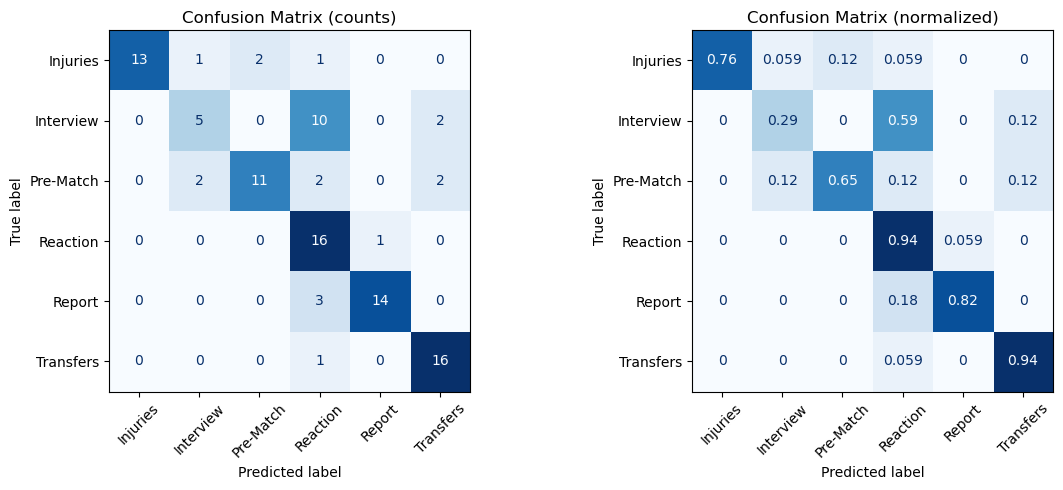

In [19]:
# Confusion matrices (counts + row-normalized)
labels_idx = list(range(len(le.classes_)))
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

cm_raw  = confusion_matrix(gold, preds, labels=labels_idx)
ConfusionMatrixDisplay(cm_raw, display_labels=le.classes_).plot(ax=ax[0], cmap="Blues", colorbar=False)
ax[0].set_title("Confusion Matrix (counts)")
ax[0].tick_params(axis='x', rotation=45)

cm_norm = confusion_matrix(gold, preds, labels=labels_idx, normalize="true")
ConfusionMatrixDisplay(cm_norm, display_labels=le.classes_).plot(ax=ax[1], cmap="Blues", colorbar=False)
ax[1].set_title("Confusion Matrix (normalized)")
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Conclusions

What I achieved:

 - Final model: XLM-RoBERTa base.
 - TEST: Acc 0.73, macro-F1 0.73.
 - Strong classes: Report, Transfers, Injuries, Pre-Match (F1 ≈ 0.73–0.88).
 - Main issue: Interview ↔ Reaction confusion (Interview F1 ≈ 0.40; Reaction recall 0.94, precision 0.48).

What I'd do to make it better:

 - I'd find/generate more instances of all classes except `Reaction`.
 - To target the confusion between Interview and Reaction I'd increase `Interview` sampling weight, reduce label smoothing, Bump MAX_LEN to 192 to keep more context.